# Práctica 4b: selección de características categóricas

**Nota:** antes de implementar los siguientes métodos, debemos asegurarnos de que el `DataFrame` sólo contiene características categóricas.

### Preparación del conjunto de datos: Breast Cancer

En el conjunto de datos se encuentran datos de las pacientes con cáncer de mama con una recurrencia o no recurrencia del cáncer. Hay 286 ejemplos y nueve variables de entrada. Es un problema de clasificación binaria.

Un modelo trivial puede lograr una precisión del \(70%\) en este conjunto de datos. Un buen puntaje es de aproximadamente \(76% +/- 3%\).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
low_memory = False
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


In [2]:
file = "../../heart.csv"
df = pd.read_csv(file)
df.columns
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
for i in names:
    if(len(df[i].unique()) == 2):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b"
        }, inplace=True)
    elif(len(df[i].unique()) == 3):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b",
            x[2] : "c"
        }, inplace=True)
    elif(len(df[i].unique()) == 4):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b",
            x[2] : "c",
            x[3] : "d"
        }, inplace=True)
    elif(len(df[i].unique()) == 5):
        x =(df[i].unique())
        df[i].replace({
            x[0] : "a",
            x[1] : "b",
            x[2] : "c", 
            x[3] : "d", 
            x[4] : "e"
        }, inplace=True)
    else:
        bins=np.linspace(min(df[i]),max(df[i]),5)
        names=["a","b","c", "d"]
        df[i]=pd.cut(df[i],bins,labels=names)
df = df.dropna()
df.to_csv("Archivo.csv", header = True, index = False)

In [3]:
file = "Archivo.csv"
data = pd.read_csv(file, header=None)
# arreglo
dataset = data.values

Una vez cargado el conjunto de datos, podemos dividirlo en datos de entrada o características (X) y salida variable de salida o target (y).

In [4]:
X = dataset[:, :-1]
y = dataset[:,-1]

Podemos forzar que todos los campos de los datos de entrada sean `string`, por si acaso Pandas malinterpretara alguna variable.

In [5]:
X = X.astype(str)

Podemos juntar este proceso en una función que podemos reutilizar más tarde.

In [6]:

def load_dataset(filename):
    # Cargamos el Dataframe
    data = pd.read_csv(filename, header=None)
    # Generamos un arreglo
    dataset = data.values
    # Dividimos en X y y
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # Forzamos que X sea string 
    X = X.astype(str)
    return X, y

Una vez cargados los datos, podemos dividirlos en conjuntos de entrenamiento (*train*) y pruebas (*test*) para que podamos encontar y evaluar un modelo de aprendizaje. Utilizaremos la función `train_test_split()` de scikit-learn y utilizaremos el 67% de los datos para el entrenamiento y el 33% para las pruebas.

In [7]:
# Cargamos el dataset
X, y = load_dataset(file)

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Checamos las dimensiones
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (136, 13) (136,)
Test (67, 13) (67,)


Podemos usar el `OrdinalEncoder()` de scikit-learn para codificar cada variable categórica a números enteros. Esta es una clase flexible y permite especificar el orden de las categorías como argumentos si se conoce dicho orden.

In [8]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    oe.fit(X_test)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)



También necesitamos preparar la variable target. Este un problema de clasificación binaria, por lo que necesitamos convertir las dos etiquetas categóricas a binarias, 0 y 1, este es un tipo de codificación ordinal. Scikit-learn proporciona la clase `LabelEncoder` diseñada específicamente para este propósito. Podríamos usar el `OrdinalEncoder` y obtener el mismo resultado, aunque el `LabelEncoder` está diseñado para codificar una sola variable.

La función `prepare_targets()` codifica los datos de salida para el train y test.

In [9]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    le.fit(y_test)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Chi-Squared

La prueba de hipótesis estadística chi-cuadrado de Pearson (Chi-squared) es un ejemplo de una prueba de independencia entre variables categóricas. Los resultados de esta prueba se pueden utilizar para la selección de características, donde aquellas características que son independientes de la variable objetivo se pueden eliminar del conjunto de datos.

La función `chi2()` puede utilizarse para la selección de las características más relevantes de k (valores más grandes) a través de la clase `SelectKBest`. Por ejemplo, podemos definir la clase `SelectKBest` para utilizar la función `chi2()` y seleccionar todas las características.

In [10]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [11]:
# Selección de características con chi-squared
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 2.165528
Característica 1: 15.040459
Característica 2: 25.838231
Característica 3: 12.263018
Característica 4: 10.269817
Característica 5: 1.631751
Característica 6: 13.994354
Característica 7: 10.823156
Característica 8: 19.213083
Característica 9: 29.545917
Característica 10: 2.919848
Característica 11: 49.437112
Característica 12: 6.514013


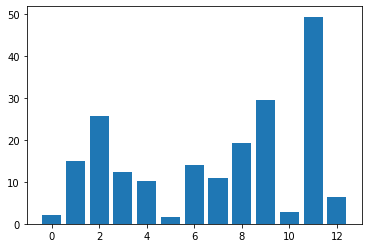

In [12]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Selección de características de información mutua (Mutual Information)

La información mutua del campo de la teoría de la información es la aplicación de la ganancia de información (típicamente usada en la construcción de árboles de decisión) a la selección de características. La información mutua se calcula entre dos variables y mide la reducción de la incertidumbre de una variable dado un valor conocido de la otra variable.

Al igual que `chi2()`, puede utilizarse en la estrategia de selección de características de `SelectKBest` (y otras estrategias).

In [13]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [14]:
# Selección de características con mutual information
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 0.041010
Característica 1: 0.031847
Característica 2: 0.172854
Característica 3: 0.010449
Característica 4: 0.050304
Característica 5: 0.048772
Característica 6: 0.057806
Característica 7: 0.077452
Característica 8: 0.136407
Característica 9: 0.005257
Característica 10: 0.098065
Característica 11: 0.168720
Característica 12: 0.147726


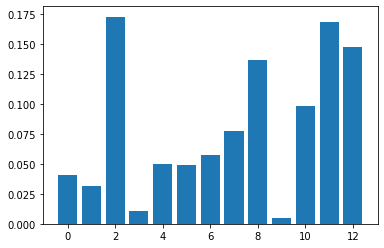

In [15]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()